In [1]:
# imports and setting random seed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import copy
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
np.random.seed(42)

## Working with STL-10 (https://cs.stanford.edu/ acoates/stl10/) DATASET

In [2]:
train_dataset = datasets.STL10(root='./data', split='train', download=True)
validation_set = datasets.STL10(root='./data', split='train', download=True)
test_dataset = datasets.STL10(root='./data', split='test', download=True)

100%|██████████| 2.64G/2.64G [00:53<00:00, 49.2MB/s]


In [3]:
# Wrap the dataset with a DataLoader for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
labels = {
    0 : "Airplane",
    1 : "Bird",
    2 : "Car",
    3 : "Cat",
    4 : "Deer",
    5 : "Dog",
    6 : "Horse",
    7 : "Monkey",
    8 : "Ship",
    9 : "Truck"
}

In [5]:
train_dataset.data.shape, train_dataset.labels.shape

((5000, 3, 96, 96), (5000,))

In [6]:
def plot_image(img, title, ax):
    ax.imshow(np.transpose(img, (1, 2, 0)))

In [7]:
train_dataset.data.shape

(5000, 3, 96, 96)

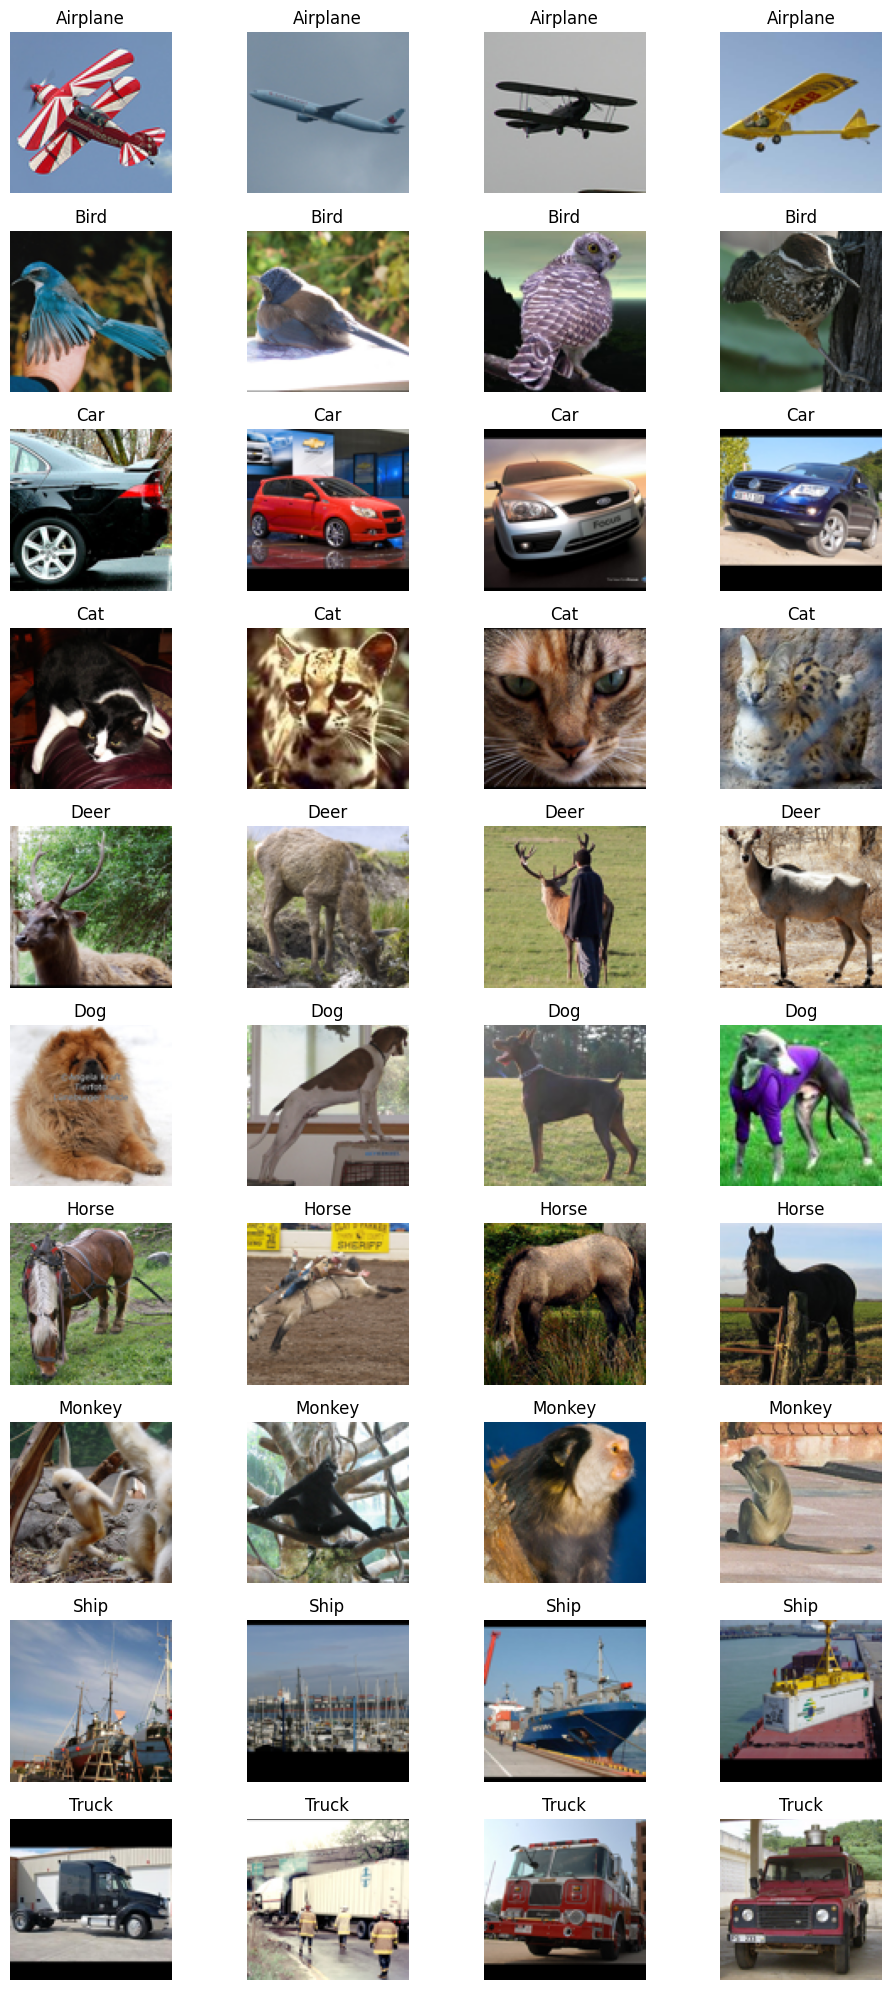

In [8]:
# plot 4 different examples from each class
# configure the plot
fig, axes = plt.subplots(nrows = 10, ncols = 4, figsize=(10,20))
# iterate over 10 classes
for i in range(10):
    # Filter data for this class
    class_i_examples = train_dataset.data[train_dataset.labels == i]

    # Pick 4 random indices
    idx = np.random.randint(0, class_i_examples.shape[0], 4)

    for j in range(4):
        img = class_i_examples[idx[j]]
        ax = axes[i, j]

        # Call the fixed function
        plot_image(img, labels[i], ax)
        ax.set_title(labels[i])

        # Remove axis ticks for cleanliness
        ax.axis("off")
plt.tight_layout()
plt.show()



In [9]:
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [10]:
targets = train_dataset.labels
train_idx, val_idx = train_test_split(
    np.arange(len(train_dataset)),
    test_size=0.2,
    shuffle=True,
    stratify=targets
)

In [11]:
train_transform = transforms.Compose([
    # Random crop 64x64
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    # Always crop the exact center 64x64
    transforms.CenterCrop(64),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset.transform = train_transform
test_dataset.transform = train_transform

In [12]:
train_set = Subset(train_dataset, train_idx)
val_set = Subset(validation_set, val_idx)

In [13]:
print(f"Train Size: {len(train_dataset)} | Val Size: {len(validation_set)} | Test Size: {len(test_dataset)}")

Train Size: 5000 | Val Size: 5000 | Test Size: 8000


In [14]:
from torch import optim
from torch import nn

In [15]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
import torch.nn.functional as F
class CNN(nn.Module):
   def __init__(self, num_classes=10, fc_size=512, dropout_rate=0.5):
      super(CNN, self).__init__()

      # Conv Blocks
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
      self.bn1 = nn.BatchNorm2d(32)

      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.bn2 = nn.BatchNorm2d(64)

      self.pool = nn.MaxPool2d(2, 2)
      # Input image is now 64x64
      # After Pool 1 -> 32x32
      # After Pool 2 -> 16x16
      # Flatten size: 64 channels * 16 * 16 = 16,384
      self.fc1 = nn.Linear(64 * 16 * 16, 512)

      self.dropout = nn.Dropout(p=0.5)
      self.fc2 = nn.Linear(512, 128)
      self.fc3 = nn.Linear(128, num_classes)

   def forward(self, x):
      # Block 1
      x = self.conv1(x)
      x = self.bn1(x)
      x = F.relu(x)
      x = self.pool(x) # 64 -> 32

      # Block 2
      x = self.conv2(x)
      x = self.bn2(x)
      x = F.relu(x)
      x = self.pool(x) # 32 -> 16

      # Flatten
      x = x.view(x.size(0), -1)

      # FC Layers
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout(x)

      x = self.fc2(x)
      x = F.relu(x)
      x = self.dropout(x)

      x = self.fc3(x)
      return x



In [17]:
# Instantiate the model
model = CNN(num_classes=10)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [18]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Standard accuracy calculation
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [19]:
def data_collator(data):
    images, labels = zip(*data)

    # Stack images into a single tensor (Batch, 3, 64, 64)
    pixel_values = torch.stack(images)
    # Stack labels into a single tensor
    labels = torch.tensor(labels)

    # Return dictionary with specific keys
    return {
        "pixel_values": pixel_values,
        "labels": labels
    }

In [20]:
class CNNTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(inputs.get("pixel_values"))
        loss = nn.CrossEntropyLoss()(outputs, labels)
        return (loss, outputs) if return_outputs else loss

In [21]:
def run_experiment(config, train_data, val_data, test_data):
    print(f"\n>>> Running Experiment: {config['name']}")

    # Initialize Model
    model = CNN(fc_size=config['fc_size'], dropout_rate=config['dropout'])

    # Define Training Args
    training_args = TrainingArguments(
        output_dir=f"./results/{config['name']}",
        num_train_epochs=config['epochs'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        learning_rate=config['lr'],
        weight_decay=config['reg'],      # Regularization Coefficient
        logging_strategy="epoch",        # Log every epoch for clean plots
        eval_strategy="epoch",     # Val every epoch
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        remove_unused_columns=False,     # Keep 'pixel_values'
        report_to="none",
        use_cpu=False                    # Set True if no GPU
    )

    # Initialize Trainer
    trainer = CNNTrainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    # Train
    trainer.train()

    # Test Evaluation
    test_results = trainer.evaluate(test_data)

    # Extract History for Plotting
    # log_history is a list of dicts. We need to separate train vs eval logs.
    history = trainer.state.log_history

    return {
        "test_acc": test_results['eval_accuracy'],
        "history": history,
        "config": config
    }

In [22]:
configs = [
    {
        'name': 'Baseline (SGD)',
        'fc_size': 512, 'batch_size': 32, 'lr': 0.01, 'reg': 0.0,
        'dropout': 0.5, 'epochs': 10, 'optimizer': 'SGD' # Note: Trainer defaults to AdamW, see note below*
    },
    {
        'name': 'Adam + High Reg',
        'fc_size': 512, 'batch_size': 64, 'lr': 1e-3, 'reg': 1e-3,
        'dropout': 0.5, 'epochs': 10, 'optimizer': 'AdamW'
    },
    {
        'name': 'Large Model (1024)',
        'fc_size': 1024, 'batch_size': 32, 'lr': 5e-4, 'reg': 1e-4,
        'dropout': 0.6, 'epochs': 10, 'optimizer': 'AdamW'
    }
]

In [23]:
results = {}
for conf in configs:
    results[conf['name']] = run_experiment(conf, train_set, val_set, test_dataset)


>>> Running Experiment: Baseline (SGD)


Epoch,Training Loss,Validation Loss


TypeError: expected Tensor as element 0 in argument 0, but got Image